# LeNet for Traffic Sign V5
![LeNet Architecture](lenet.png)
Modified from source: Yan LeCun

Author: Peng "Patrick" Su
Augmenting the under-sampled data, to make it better-balanced

## Load Data

Load the traffic sign data

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import cv2
%matplotlib inline

In [25]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = '../traffic-signs-data/train.p'
validation_file = '../traffic-signs-data/valid.p'
testing_file = '../traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

The traffic sign data comes as 32x32x3 images, and LeNet accepts 32x32xC images. No need to pad anything. 

## Preprocess Data

Shuffle the training data.

You do not need to modify this section.

In [26]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

In [27]:
y_train_DF = pd.DataFrame(y_train, columns=['label'])
group_count = y_train_DF.groupby(['label']).size()
print('Label {} has the max amount of data, {}'.format(np.argmax(group_count), np.max(group_count)))
print('Label {} has the min amount of data, {}'.format(np.argmin(group_count), np.min(group_count)))
print("Next, Let's augment the undersampled classes to the max count")
max_count = np.max(group_count)

Label 2 has the max amount of data, 2010
Label 0 has the min amount of data, 180
Next, Let's augment the undersampled classes to the max count


In [28]:
from skimage import transform, filters, exposure
import cv2
def augment_image(img,angle_range=(-5, 5),shear_range=10,trans_range=5,brightness=0):
    # rotation
    angle = np.random.uniform(*angle_range)
    rows, cols, _ = img.shape
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2), angle, 1)
    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])
    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2
    # Brightness
    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])
    shear_M = cv2.getAffineTransform(pts1,pts2)

    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))

    if brightness == 1:
        img = augment_brightness_camera_images(img)
    
    return img.astype(np.uint8)

In [29]:
X_train.shape[1:]

(32, 32, 3)

In [30]:
def augment_data(X, y, group_count):
    augmented_X = np.zeros([max_count*43, *X.shape[1:]], dtype = np.uint8)
    augmented_y = np.zeros([max_count*43, *y.shape[1:]], dtype = np.uint8)
    for label,count in enumerate(group_count):
        perLabelData = X[y==label]
        augmented_X[label*max_count:label*max_count+count] = perLabelData
        for i in range(max_count - count):
            ind = np.random.randint(0, count)
#             new_img = augment_image(perLabelData[ind])
#             augmented_X[label*max_count+count+i] = new_img
            augmented_X[label*max_count+count+i] = perLabelData[ind]
        augmented_y[label*max_count:label*max_count+max_count] = label  
    return augmented_X, augmented_y
X_train, y_train = augment_data(X_train, y_train, group_count)

In [31]:
X_train.shape

(86430, 32, 32, 3)

In [32]:
def normalize(img):
    return (img - 128.)/128.
def hist_eq(img):
    if (len(img.shape)>3): # if you're passing in a collection of images
        num_images = img.shape[0]
        image_shape = img.shape[1:]
        locEqImg = np.zeros([num_images,image_shape[0],image_shape[1],image_shape[2]])
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(6,6))
        for i in range(num_images):
            currImg = img[i].squeeze()
            img_lab = cv2.cvtColor(currImg, cv2.COLOR_RGB2LAB)
            img_lab[:,:,0]=clahe.apply(img_lab[:,:,0])
            tmp = cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)
            locEqImg[i] = tmp
    else:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(6,6))
        img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        img_lab[:,:,0]=clahe.apply(img_lab[:,:,0])
        tmp = cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)
        locEqImg = tmp
    return locEqImg

X_train = hist_eq(X_train)
X_train = normalize(X_train)
X_train = X_train.astype('float32')

X_valid = hist_eq(X_valid)
X_valid = normalize(X_valid)
X_valid = X_valid.astype('float32')

X_test = hist_eq(X_test)
X_test = normalize(X_test)
X_test = X_test.astype('float32')

In [34]:
X_train.shape

(86430, 32, 32, 3)

In [35]:
X_train.dtype

dtype('float32')

## Setup TensorFlow
The `EPOCH` and `BATCH_SIZE` values affect the training speed and model accuracy.

You do not need to modify this section.

In [36]:
import tensorflow as tf

## TODO: Implement LeNet-5
Implement the [LeNet-5](http://yann.lecun.com/exdb/lenet/) neural network architecture.

This is the only cell you need to edit.
### Input
The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels. Since MNIST images are grayscale, C is 1 in this case.

### Architecture
**Layer 1: Convolutional.** The output shape should be 28x28x6.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 14x14x6.

**Layer 2: Convolutional.** The output shape should be 10x10x16.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 5x5x16.

**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using `tf.contrib.layers.flatten`, which is already imported for you.

**Layer 3: Fully Connected.** This should have 120 outputs.

**Activation.** Your choice of activation function.

**Layer 4: Fully Connected.** This should have 84 outputs.

**Activation.** Your choice of activation function.

**Layer 5: Fully Connected (Logits).** This should have 10 outputs.

### Output
Return the result of the 2nd fully connected layer.

In [38]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    weights = {
        'wc1': tf.Variable(tf.truncated_normal([5,5,3,6], mu, sigma)),
        'wc2': tf.Variable(tf.truncated_normal([5,5,6,16], mu, sigma)),
        'wf3': tf.Variable(tf.truncated_normal([5*5*16, 120], mu, sigma)),
        'wf4': tf.Variable(tf.truncated_normal([120, 84], mu, sigma)),
        'wf5': tf.Variable(tf.truncated_normal([84, 43], mu, sigma))}
    biases = {
        'bc1': tf.zeros([6]),
        'bc2': tf.zeros([16]),
        'bf3': tf.zeros([120]),
        'bf4': tf.zeros([84]),
        'bf5': tf.zeros([43]),
    }
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1 = tf.nn.conv2d(x, weights['wc1'], strides = [1, 1, 1, 1], padding = 'VALID')
    conv1 = tf.nn.bias_add(conv1, biases['bc1'])
    # TODO: Activation.
    conv1 = tf.nn.relu(conv1)    
    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'VALID')
    conv1 = tf.nn.dropout(conv1, keep_prob)
#     flat1 = flatten(conv1, [-1, 14*14*6])
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    conv2 = tf.nn.conv2d(conv1, weights['wc2'], strides = [1, 1, 1, 1], padding = 'VALID')
    conv2 = tf.nn.bias_add(conv2, biases['bc2'])    
    # TODO: Activation.
    conv2 = tf.nn.relu(conv2)
    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'VALID')
    conv2 = tf.nn.dropout(conv2, keep_prob)
    # TODO: Flatten. Input = 5x5x8. Output = 200.

#     flat2 = flatten(conv2, [-1, 5*5*16])
#     flat = tf.concat(1, [flat1, flat2])
    
    flat = flatten(conv2, [-1, 5*5*16])
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc3 = tf.add(tf.matmul(flat, weights['wf3']), biases['bf3'])
    # TODO: Activation.
    fc3 = tf.nn.relu(fc3)
    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc4 = tf.add(tf.matmul(fc3, weights['wf4']), biases['bf4'])
    # TODO: Activation.
    fc4 = tf.nn.relu(fc4)
    # TODO: Layer 5: Fully Connected. Input = 84. Output = 43.
    logits = tf.add(tf.matmul(fc4, weights['wf5']), biases['bf5'])
    
    return logits

## Features and Labels
Train LeNet to classify traffic sign data.

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.

You do not need to modify this section.

In [39]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder(tf.float32)

## Training Pipeline
Create a training pipeline that uses the model to classify MNIST data.

You do not need to modify this section.

In [40]:
rate = 0.001
logits = LeNet(x)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

You do not need to modify this section.

In [41]:
saver = tf.train.Saver(max_to_keep=100)

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        loss, accuracy = sess.run([loss_operation, accuracy_operation], feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        total_accuracy += (accuracy * len(batch_x))
        total_loss += (loss * len(batch_x))
    return total_loss / num_examples, total_accuracy / num_examples

## Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.

You do not need to modify this section.

In [42]:
import shutil
save_dir = 'LeNetV5'
out_dir = out_dir = os.path.abspath(os.path.join(os.path.curdir, "../Traffic-Sign-Classifier-runs", save_dir))
if os.path.exists(out_dir):
    shutil.rmtree(out_dir)
train_summary_dir = os.path.join(out_dir, "train")        
valid_summary_dir = os.path.join(out_dir, "valid")
checkpoint_dir = os.path.join(out_dir, "checkpoints")
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir,"model")
checkpoint_every = 100
train_summary_every = 100
valid_summary_every = 100

EPOCHS = 20
BATCH_SIZE = 128

In [43]:

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    global_step = 0
    train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)
    valid_summary_writer = tf.summary.FileWriter(valid_summary_dir, sess.graph)
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:0.7})
            global_step += 1
            if global_step % train_summary_every == 0:
                train_loss, train_accuracy = evaluate(batch_x, batch_y)
                train_summaries = tf.Summary()
                train_summaries.value.add(tag='Train Loss', simple_value=train_loss)
                train_summaries.value.add(tag='Train Accuracy', simple_value=train_accuracy)
                train_summary_writer.add_summary(train_summaries, global_step)
                print("Batch {} Train Loss: {:.3f} Train Accuracy: {:.3f}".format(global_step, train_loss, train_accuracy))
                print()
            if global_step % valid_summary_every == 0:
                validation_loss, validation_accuracy = evaluate(X_valid, y_valid)
                valid_summaries = tf.Summary()
                valid_summaries.value.add(tag='Validation Loss', simple_value=validation_loss)
                valid_summaries.value.add(tag='Validation Accuracy', simple_value=validation_accuracy)
                print("valid writing")
                valid_summary_writer.add_summary(valid_summaries, global_step)
                print("EPOCH {} Batch {} ...".format(i+1, global_step))
                print("Validation loss = {:.3f}".format(validation_loss))
                print("Validation Accuracy = {:.3f}".format(validation_accuracy))
                print()
            if global_step % checkpoint_every == 0:
                saver.save(sess, checkpoint_prefix, global_step=global_step)            
    print("Training Done")

Training...

Batch 100 Train Loss: 1.564 Train Accuracy: 0.531

valid writing
EPOCH 1 Batch 100 ...
Validation loss = 1.693
Validation Accuracy = 0.486

Batch 200 Train Loss: 0.533 Train Accuracy: 0.891

valid writing
EPOCH 1 Batch 200 ...
Validation loss = 0.855
Validation Accuracy = 0.760

Batch 300 Train Loss: 0.343 Train Accuracy: 0.898

valid writing
EPOCH 1 Batch 300 ...
Validation loss = 0.602
Validation Accuracy = 0.837

Batch 400 Train Loss: 0.241 Train Accuracy: 0.938

valid writing
EPOCH 1 Batch 400 ...
Validation loss = 0.517
Validation Accuracy = 0.875

Batch 500 Train Loss: 0.190 Train Accuracy: 0.961

valid writing
EPOCH 1 Batch 500 ...
Validation loss = 0.455
Validation Accuracy = 0.878

Batch 600 Train Loss: 0.122 Train Accuracy: 0.969

valid writing
EPOCH 1 Batch 600 ...
Validation loss = 0.442
Validation Accuracy = 0.874

Batch 700 Train Loss: 0.136 Train Accuracy: 0.984

valid writing
EPOCH 2 Batch 700 ...
Validation loss = 0.409
Validation Accuracy = 0.893

Batch 8

Batch 5900 Train Loss: 0.016 Train Accuracy: 0.992

valid writing
EPOCH 9 Batch 5900 ...
Validation loss = 0.213
Validation Accuracy = 0.955

Batch 6000 Train Loss: 0.021 Train Accuracy: 0.992

valid writing
EPOCH 9 Batch 6000 ...
Validation loss = 0.202
Validation Accuracy = 0.955

Batch 6100 Train Loss: 0.011 Train Accuracy: 1.000

valid writing
EPOCH 10 Batch 6100 ...
Validation loss = 0.219
Validation Accuracy = 0.951

Batch 6200 Train Loss: 0.015 Train Accuracy: 1.000

valid writing
EPOCH 10 Batch 6200 ...
Validation loss = 0.211
Validation Accuracy = 0.957

Batch 6300 Train Loss: 0.039 Train Accuracy: 0.992

valid writing
EPOCH 10 Batch 6300 ...
Validation loss = 0.220
Validation Accuracy = 0.953

Batch 6400 Train Loss: 0.024 Train Accuracy: 0.984

valid writing
EPOCH 10 Batch 6400 ...
Validation loss = 0.265
Validation Accuracy = 0.944

Batch 6500 Train Loss: 0.020 Train Accuracy: 0.992

valid writing
EPOCH 10 Batch 6500 ...
Validation loss = 0.199
Validation Accuracy = 0.952

B

Batch 11700 Train Loss: 0.004 Train Accuracy: 1.000

valid writing
EPOCH 18 Batch 11700 ...
Validation loss = 0.225
Validation Accuracy = 0.959

Batch 11800 Train Loss: 0.015 Train Accuracy: 1.000

valid writing
EPOCH 18 Batch 11800 ...
Validation loss = 0.236
Validation Accuracy = 0.951

Batch 11900 Train Loss: 0.004 Train Accuracy: 1.000

valid writing
EPOCH 18 Batch 11900 ...
Validation loss = 0.229
Validation Accuracy = 0.959

Batch 12000 Train Loss: 0.003 Train Accuracy: 1.000

valid writing
EPOCH 18 Batch 12000 ...
Validation loss = 0.230
Validation Accuracy = 0.956

Batch 12100 Train Loss: 0.031 Train Accuracy: 0.984

valid writing
EPOCH 18 Batch 12100 ...
Validation loss = 0.228
Validation Accuracy = 0.958

Batch 12200 Train Loss: 0.002 Train Accuracy: 1.000

valid writing
EPOCH 19 Batch 12200 ...
Validation loss = 0.230
Validation Accuracy = 0.954

Batch 12300 Train Loss: 0.005 Train Accuracy: 1.000

valid writing
EPOCH 19 Batch 12300 ...
Validation loss = 0.224
Validation Acc

## Evaluate the Model
Once you are completely satisfied with your model, evaluate the performance of the model on the test set.

Be sure to only do this once!

If you were to measure the performance of your trained model on the test set, then improve your model, and then measure the performance of your model on the test set again, that would invalidate your test results. You wouldn't get a true measure of how well your model would perform against real data.

You do not need to modify this section.

In [44]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint(checkpoint_dir))
    train_loss, train_accuracy = evaluate(X_train, y_train)
    print("Train Loss = {:.3f}".format(train_loss))
    print("Train Accuracy = {:.3f}".format(train_accuracy))

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint(checkpoint_dir))
    valid_loss, valid_accuracy = evaluate(X_valid, y_valid)
    print("Valid Loss = {:.3f}".format(valid_loss))
    print("Valid Accuracy = {:.3f}".format(valid_accuracy))

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint(checkpoint_dir))
    test_loss, test_accuracy = evaluate(X_test, y_test)
    print("Test Loss = {:.3f}".format(test_loss))
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Train Loss = 0.009
Train Accuracy = 0.998
Valid Loss = 0.257
Valid Accuracy = 0.954
Test Loss = 0.201
Test Accuracy = 0.947


In [ ]:
X_valid.shape

In [45]:
def corr_predict(X_data, y_data):
    num_examples = len(X_data)
    corr_predict = np.zeros(num_examples)
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        temp = np.array(sess.run([correct_prediction], feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})).astype('Int32')
        corr_predict[offset:offset+BATCH_SIZE] = temp
    return corr_predict

In [46]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint(checkpoint_dir))
    corr_pred = corr_predict(X_valid,y_valid)

201


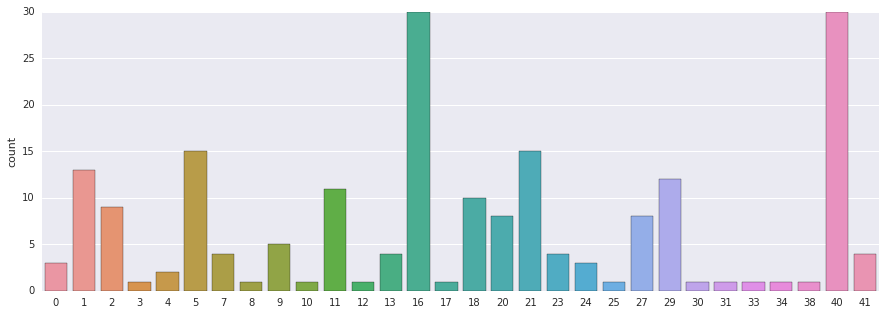

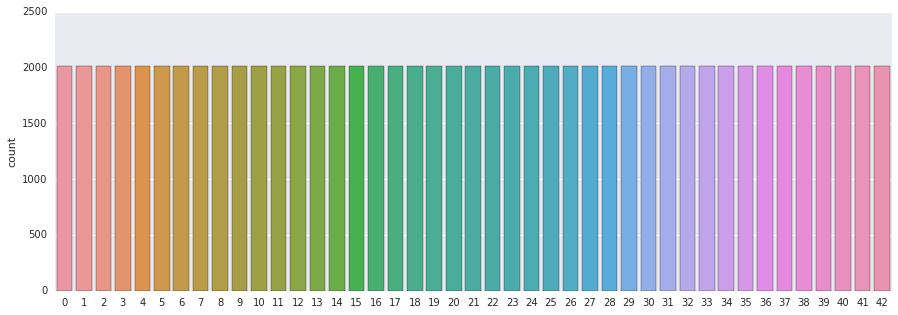

In [48]:
import seaborn as sns
print(np.sum(corr_pred == 0))
wrong_pred_indexes = np.argwhere(corr_pred == 0)
plt.figure(figsize = (15,5))
sns.countplot(y_valid[corr_pred == 0])
plt.figure(figsize = (15,5))
sns.countplot(y_train)

In [ ]:
## Let me augment the undersampled data and see what happens